In [1]:
# Regression Models
%matplotlib inline
#%matplotlib widget
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from collections import Counter
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor,
RandomForestRegressor, VotingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor)

# Preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler ,OneHotEncoder, MinMaxScaler, PolynomialFeatures

# model_selection
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, 
learning_curve, cross_val_predict, cross_validate, permutation_test_score, validation_curve, RandomizedSearchCV)

# Metrics
from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score,
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc, classification_report, f1_score)

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

In [2]:
dmax = pd.read_csv('daily-max-temperatures.csv')
dmin = pd.read_csv('daily-min-temperatures.csv')

In [3]:
dmax.head(3)

,Date,Temperature
0,1981-01-01,38.1
1,1981-01-02,32.4
2,1981-01-03,34.5


In [4]:
dmin.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [5]:
# Merge both dataframes
df = pd.merge(dmax, dmin, how='left', left_on='Date', right_on='Date')

In [6]:
# Lowering columns
df.columns = df.columns.str.lower() 

In [7]:
# Rename columns
df.rename(columns={'temp':'min_temp', 'temperature':'max_temp'}, inplace=True) 

In [8]:
# shift column to any position 
first_column = df.pop('min_temp')

# Moving the column to the position you want
df.insert(1, 'min_temp', first_column)

In [9]:
# Data Integrity Check
print("Big Query Statistics:")
print('-' * 127)
print(f"🚣‍♀️ DataFrame Shape: {df.shape}")
print('-' * 127)
print(f"Columns to list:\n{df.columns.tolist()}")
print('-' * 127)
print(f"📊 DataFrame Info: {df.info(memory_usage='deep')}")
print('-' * 127)
print(f"📈 DataFrame Distribution:\n {df.describe()}")

Big Query Statistics:
-------------------------------------------------------------------------------------------------------------------------------
🚣‍♀️ DataFrame Shape: (3650, 3)
-------------------------------------------------------------------------------------------------------------------------------
Columns to list:
['date', 'min_temp', 'max_temp']
-------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      3650 non-null   object 
 1   min_temp  3650 non-null   float64
 2   max_temp  3650 non-null   float64
dtypes: float64(2), object(1)
memory usage: 296.0 KB
📊 DataFrame Info: None
-------------------------------------------------------------------------------------------------------------------------------
📈 DataF

In [10]:
# Change the date to datetime format 
df['date'] = pd.to_datetime(df['date'])

In [11]:
print(f"📊 DataFrame Info: {df.info(memory_usage='deep')}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      3650 non-null   datetime64[ns]
 1   min_temp  3650 non-null   float64       
 2   max_temp  3650 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 85.7 KB
📊 DataFrame Info: None


In [12]:
missing_values = df.isna().sum()

if len(missing_values) < 0:
    print("❌ Missing data for following columns:")
else:
    print(f"✅ No missing data for df:\n{missing_values}") 

✅ No missing data for df:
date        0
min_temp    0
max_temp    0
dtype: int64


In [47]:
#df[df['date'].dt.year == 1981]

In [13]:
# Value_counts - Unique
float1 = df.select_dtypes(include=['float'])
for col in float1.columns:
    #print(f"\n{col}:")
    print(f"{'='*127}")
    print(df[col].value_counts())

min_temp
10.0    51
11.0    51
13.0    48
12.5    44
10.5    44
        ..
0.2      1
24.0     1
25.2     1
22.7     1
21.6     1
Name: count, Length: 229, dtype: int64
max_temp
18.5    42
16.0    41
15.0    40
19.0    39
14.0    36
        ..
35.6     1
39.4     1
38.2     1
43.0     1
37.6     1
Name: count, Length: 309, dtype: int64


In [14]:
# Date column engineering 
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [15]:
# mapping month column 
m_map = {1:'january', 2:'febraury', 3:'march', 4:'april', 5:'may', 6:'june', 7:'july',
      8:'august', 9:'september', 10:'october', 11:'november', 12:'december'}

df['month'] = df['month'].map(m_map)

In [16]:
# drop date column 
df.drop('date', axis=1, inplace=True)

In [17]:
# shift column to any position 
y = df.pop('year')
m = df.pop('month')
d = df.pop('day') 

# Moving the column to the position you want
df.insert(0, 'year', y)
df.insert(1, 'month', m)
df.insert(2, 'day', d)

In [18]:
# Group by multiple columns
min_temp_by_year_and_month = df.groupby(['year', 'month'])[['min_temp']]\
    .min().sort_values(by='min_temp', ascending=True)  

max_temp_by_year_and_month = df.groupby(['year', 'month'])[['max_temp']]\
    .max().sort_values(by='max_temp', ascending=False)  

In [19]:
min_temp_by_year_and_month

,,min_temp
year,month,
1982,june,0.0
1983,july,0.0
1984,july,0.1
1982,july,0.2
1985,july,0.3
...,...,...
1981,january,12.1
1982,january,12.5
1983,febraury,12.8


In [20]:
max_temp_by_year_and_month

,,max_temp
year,month,
1982,january,43.3
1983,febraury,43.2
1985,january,42.2
1981,january,41.8
1988,january,40.4
...,...,...
1982,july,17.0
1984,july,17.0
1982,june,16.9


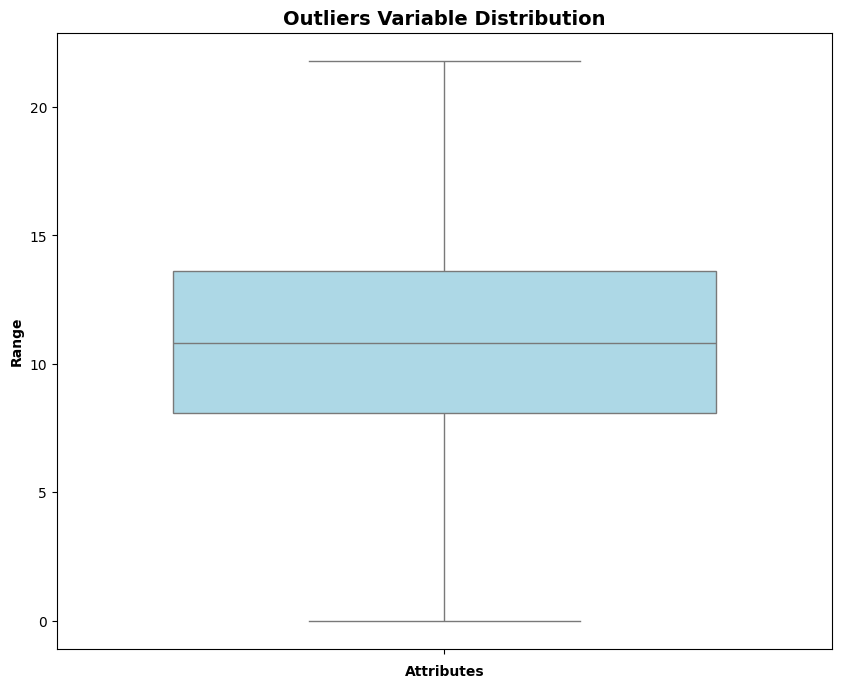

In [27]:
# Outliers
# Visualize Outlier Analysis of many columns at once
#attributes = ['Amount','Frequency','Recency']

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df['min_temp'], orient="v",  color="lightblue",
whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');

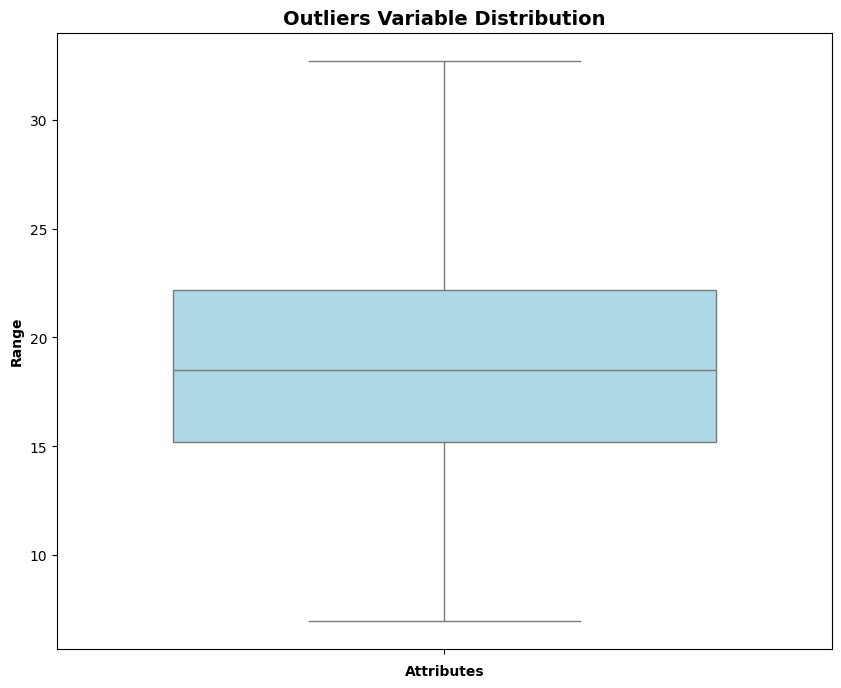

In [28]:
# Outliers
# Visualize Outlier Analysis of many columns at once
#attributes = ['Amount','Frequency','Recency']

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df['max_temp'], orient="v",  color="lightblue",
whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');

In [26]:
# Removing (statistical) outliers for any column one by one
Q1 = df.min_temp.quantile(0.25)
Q3 = df.min_temp.quantile(0.75)
IQR = Q3 - Q1
print(f"Shape {df.shape} with Outliers")
df = df[(df.min_temp >= Q1 - 1.5 * IQR) & (df.min_temp <= Q3 + 1.5 * IQR)]

# Removing (statistical) outliers for any column one by one
Q1 = df.max_temp.quantile(0.25)
Q3 = df.max_temp.quantile(0.75)
IQR = Q3 - Q1
df = df[(df.max_temp >= Q1 - 1.5 * IQR) & (df.max_temp <= Q3 + 1.5 * IQR)]
print(f"Shape {df.shape} without Outliers")  

Shape (3470, 5) with Outliers
Shape (3470, 5) without Outliers


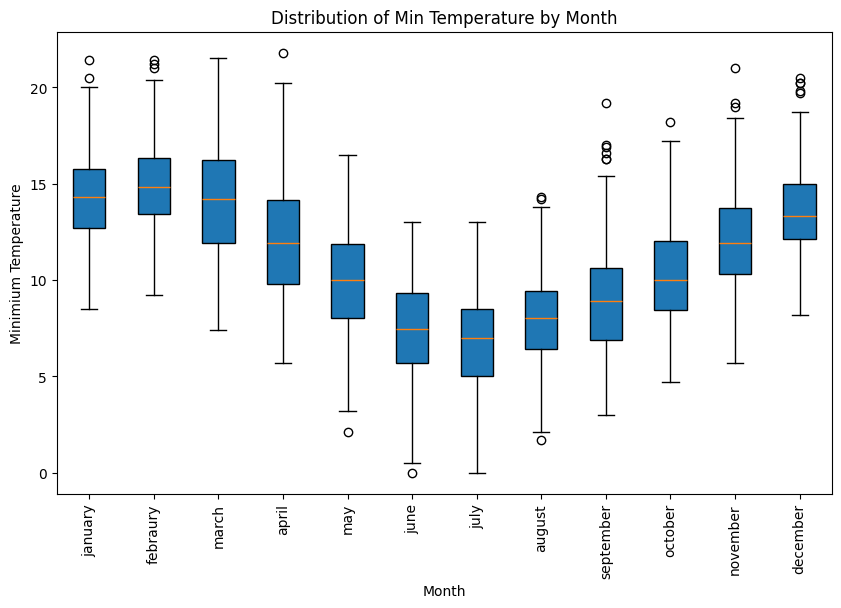

In [29]:
# Method 1: Using pandas groupby (recommended)
plt.figure(figsize=(10, 6))
data_grouped = [df[df['month'] == size]['min_temp'] for size in df['month'].unique()]
plt.boxplot(data_grouped, tick_labels=df['month'].unique(), patch_artist=True)
plt.title('Distribution of Min Temperature by Month')
plt.xlabel('Month')
plt.ylabel('Minimium Temperature')
plt.xticks(rotation=90)
plt.show()   

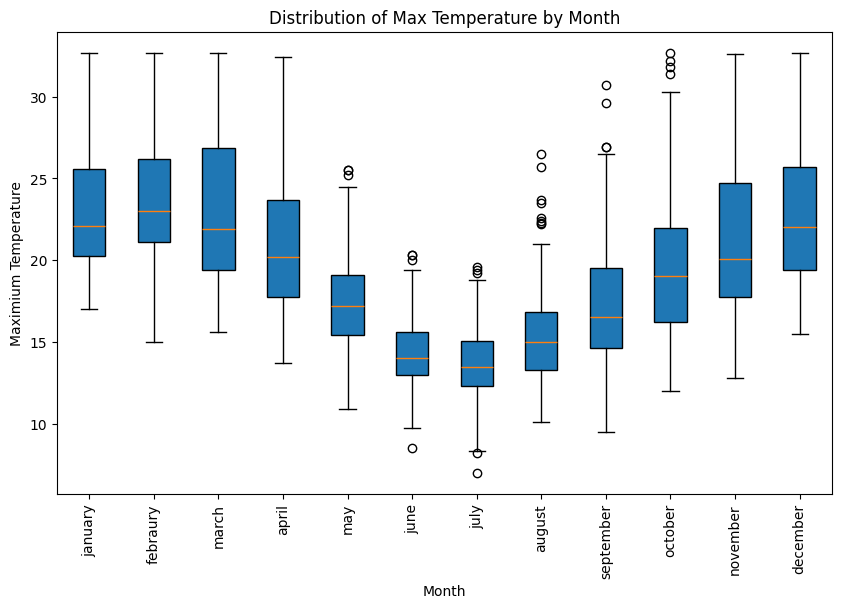

In [30]:
# Method 1: Using pandas groupby (recommended)
plt.figure(figsize=(10, 6))
data_grouped = [df[df['month'] == size]['max_temp'] for size in df['month'].unique()]
plt.boxplot(data_grouped, tick_labels=df['month'].unique(), patch_artist=True)
plt.title('Distribution of Max Temperature by Month')
plt.xlabel('Month')
plt.ylabel('Maximium Temperature')
plt.xticks(rotation=90)
plt.show()   

In [31]:
min_temp_by_year_and_month.reset_index(inplace=True)
max_temp_by_year_and_month.reset_index(inplace=True)

In [32]:
df

,year,month,day,min_temp,max_temp
1,1981,january,2,17.9,32.4
3,1981,january,4,14.6,20.7
4,1981,january,5,15.8,21.5
5,1981,january,6,15.8,23.1
6,1981,january,7,15.8,29.7
...,...,...,...,...,...
3644,1990,december,26,14.6,20.9
3646,1990,december,28,13.6,23.2
3647,1990,december,29,13.5,25.1
3648,1990,december,30,15.7,24.4
